# CET313 Assignment - House Price Predictor

__Name: Daniel Southern__

__Project: House Price Prediction Model__

# Import Libraries and Dataset

In [1]:
#import required libraries for this project
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder

In [2]:
#load dataset of house price prediction data in a panadas dataframe 
dataset = pd.read_csv("HousePricePredictorTrainset.csv")

# Exploratory Data Analysis

In [3]:
#print first three entries of dataset to see columns and structure of data entries 
dataset.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
#drop id column as it is not required for training the model to predict house prices 
dataset = dataset.drop('Id', axis=1)

#print first three entries again to check ID has been dropped 
dataset.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [5]:
#print information about columns to see Column name, non-null entries and Data type  
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

Initially through the .info() method it can be seen that there are three data types, one of which is non-numeric. There is a total of 1460 data entries although some columns contain less non-null entries which suggests that there is null data which needs to be handled before training the regression model. 

In [6]:
#print descriptive statistics for the target variable 
print(dataset['SalePrice'].describe())

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


The above statistics show that the distribution of the target variable is quite poor. The upper percentile is £214,000 however the highest value within the dataset is £755,000, this is a large gap. This may suggest that their is sparse data for prices over £214,000 therefore predictions for these properties will be less accurate. The values within the quartile should be where the model's predictions are most accurate as that  is where the most training data can be provided for. 

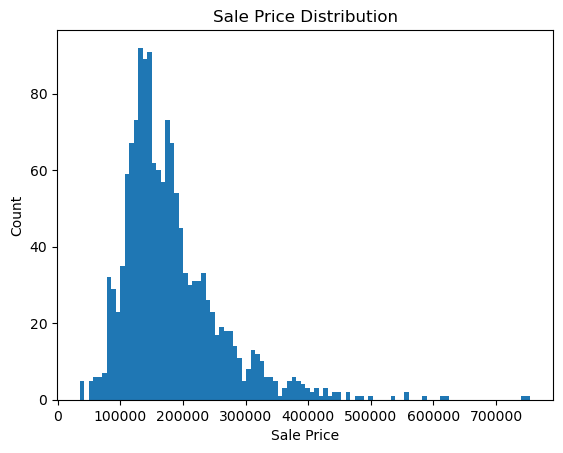

In [7]:
#visualise sale price distribution using a histogram 
plt.hist(dataset['SalePrice'], bins=100)
plt.title('Sale Price Distribution')
plt.ylabel('Count')
plt.xlabel('Sale Price')
plt.show()

This graph supports the previous observation as the majority of data is for prices between £100k - £200k. There is a significant lack of data for prices over £400k therefore the model may not perform well when predicting these values. 

In [8]:
#list all data types within the data frame
list(set(dataset.dtypes.tolist()))

[dtype('O'), dtype('float64'), dtype('int64')]

In [9]:
#count number of columns belonging to each datatype
objects = (dataset.dtypes == 'object')
object_cols = list(objects[objects].index)
print("Categorical variables:",len(object_cols))
 
integers = (dataset.dtypes == 'int64')
integer_cols = list(integers[integers].index)
print("Integer variables:",len(integer_cols))
 
floats = (dataset.dtypes == 'float64')
float_cols = list(floats[floats].index)
print("Float variables:",len(float_cols))

Categorical variables: 43
Integer variables: 34
Float variables: 3


Majority of columns are non-numeric which will need to be converted to a numeric format for the regression model. Alternatively, the categorical data could be dropped from the dataset however this would reduce the model's accuracy as it would be provided with less data to make predictions. 

In [10]:
#select numerical values to be stored in 'data_numbers' variable so that numerical columns can be analysed 
dataset_nums = dataset.select_dtypes(include = ['float64', 'int64'])
#print first 3 rows to check only numerical values remain 
dataset_nums.head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


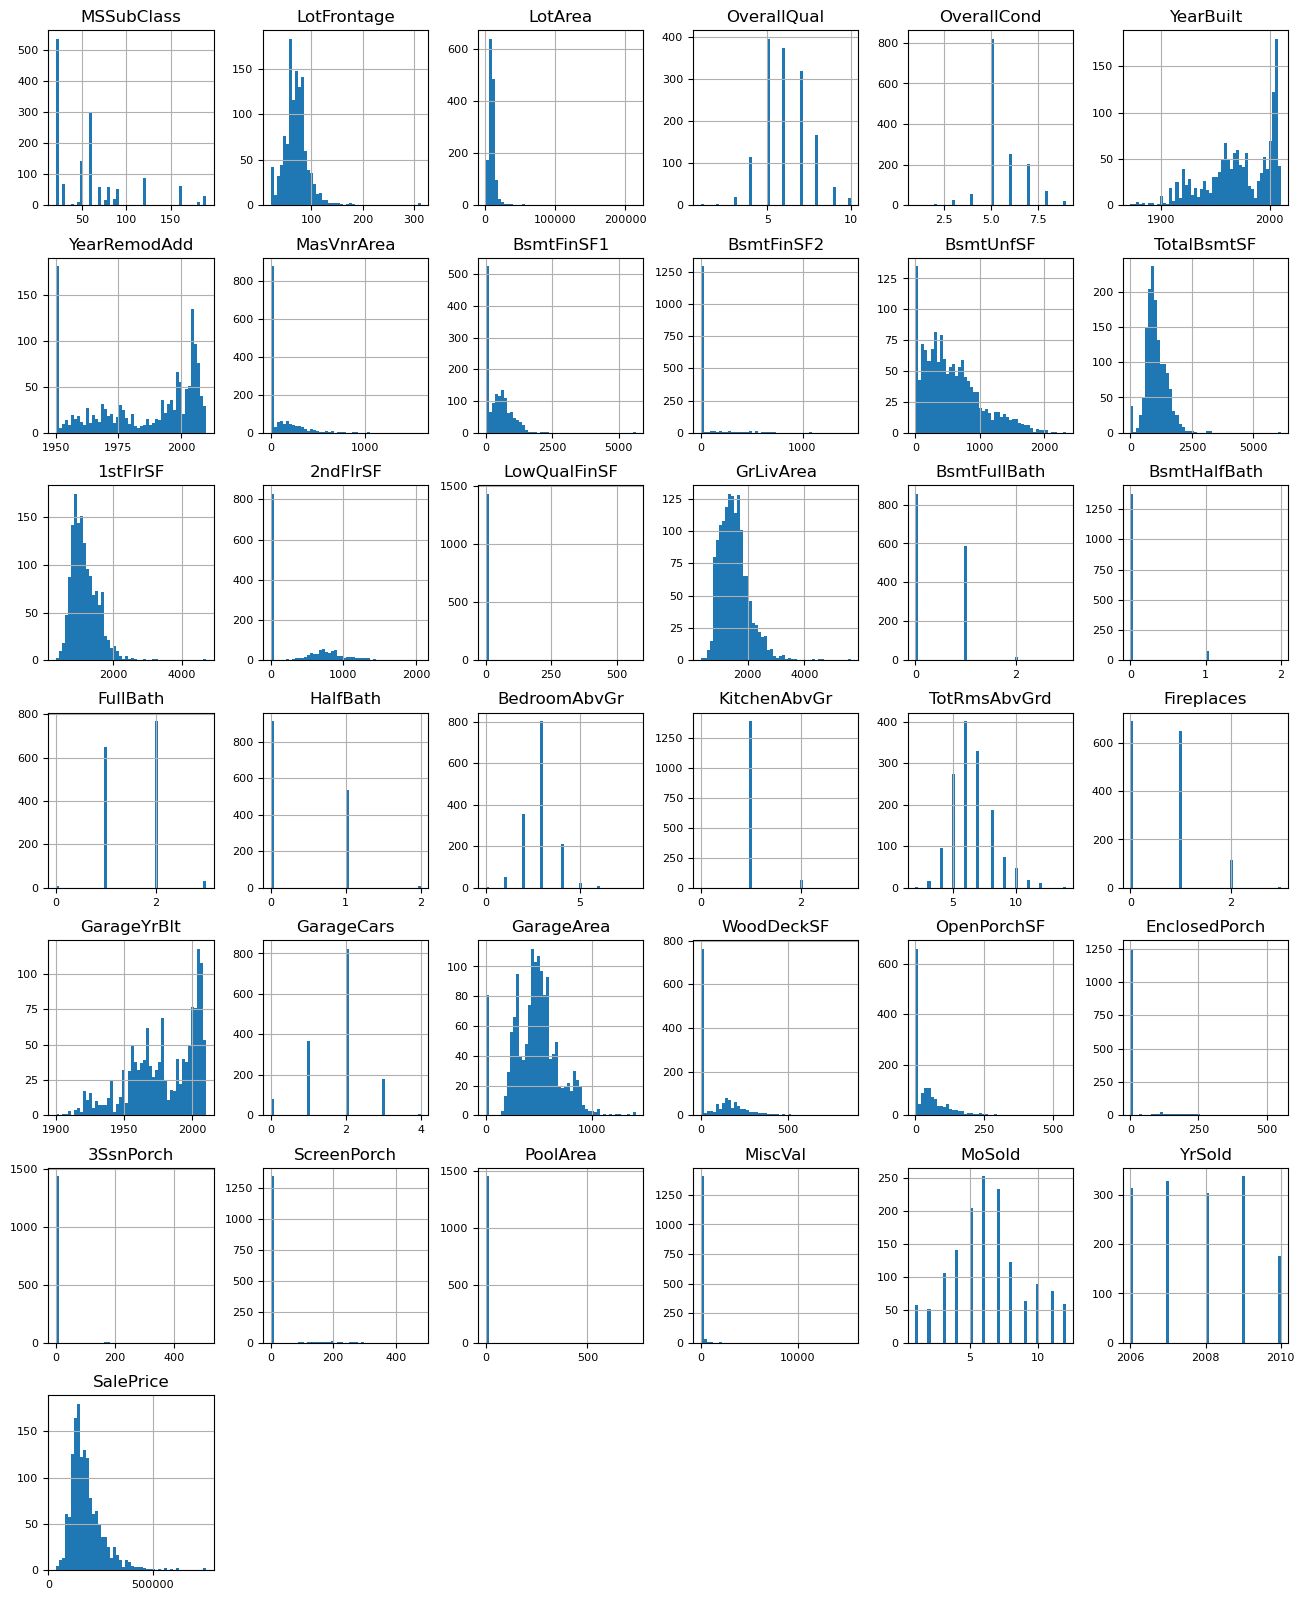

In [11]:
#plot distribution for all numerical features 
dataset_nums.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

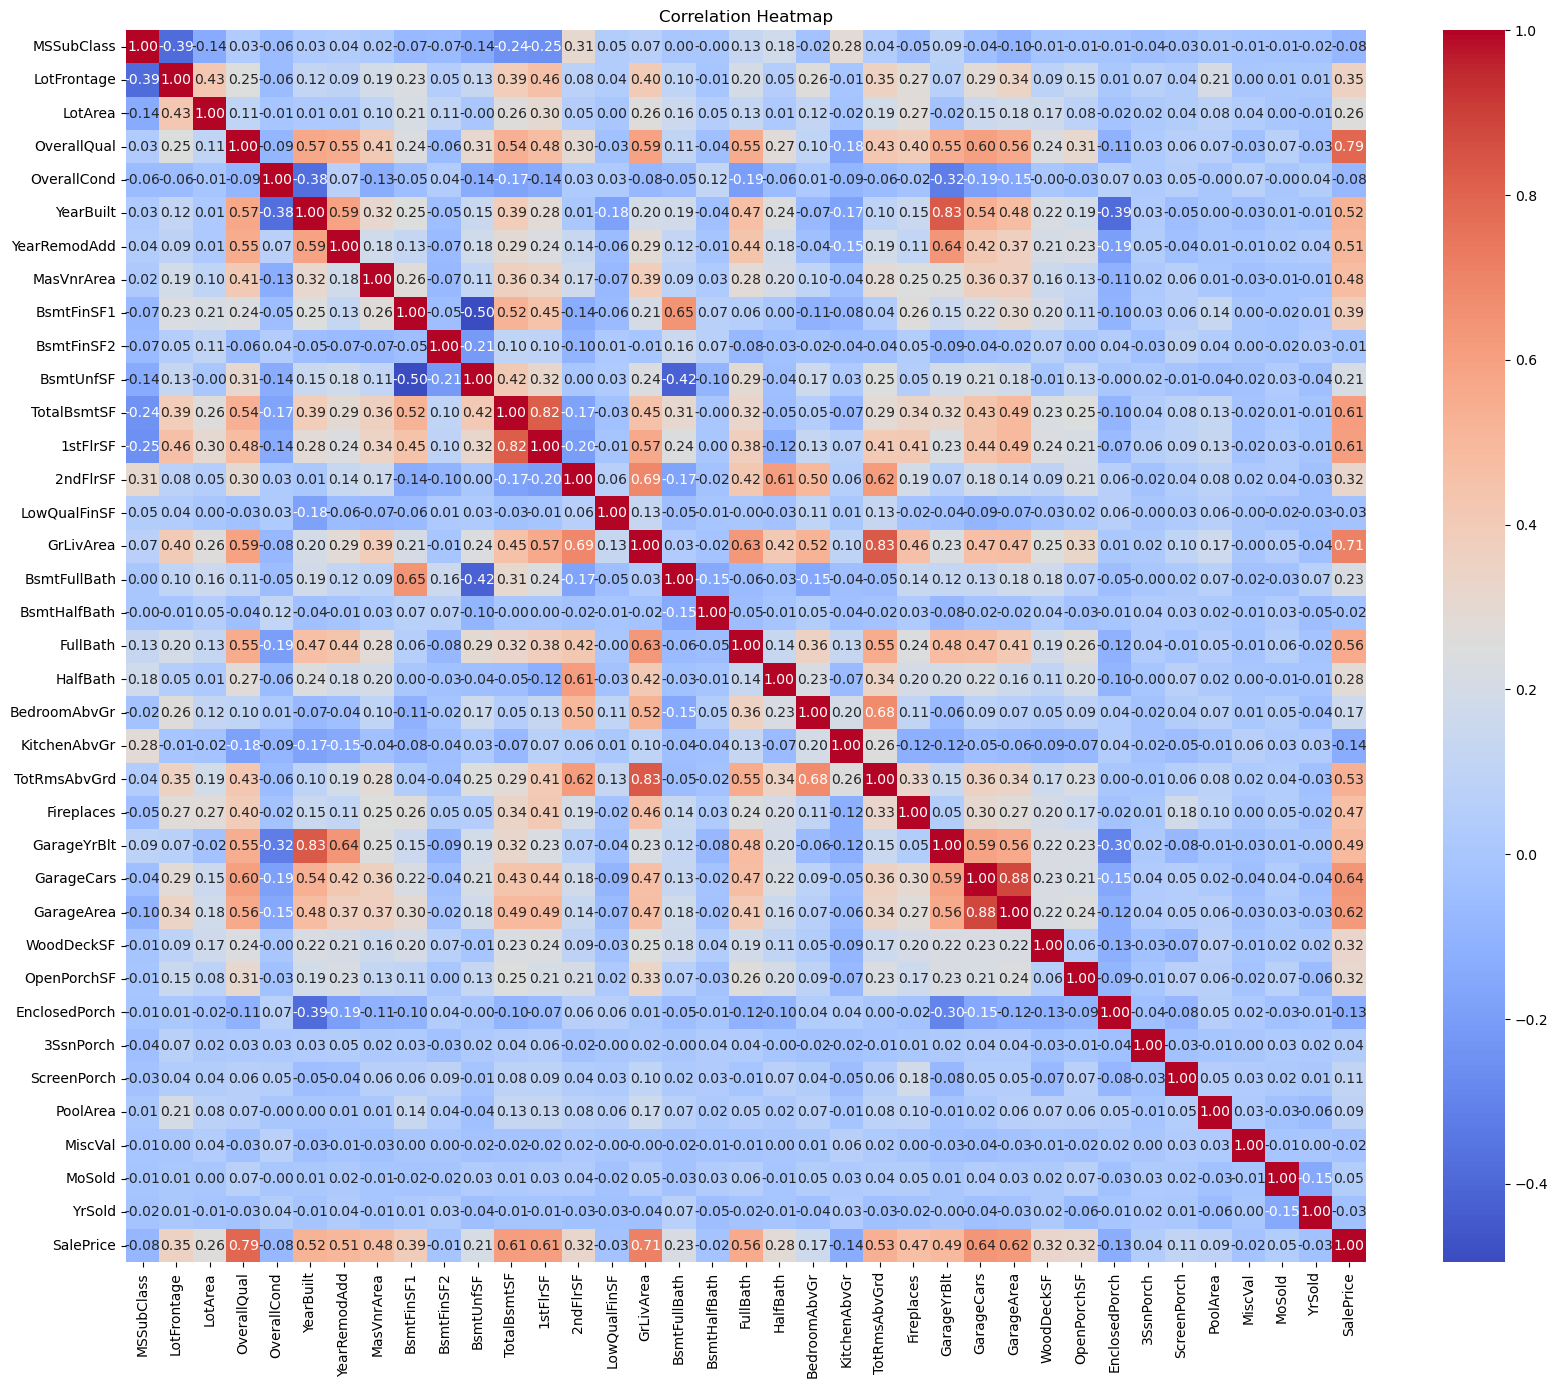

In [12]:
#correlation matrix to identify relationships between all numerical features 
correlation_matrix = dataset_nums.corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [13]:
#sort numerical features according to their correlation with SalePrice
print("Numerical Features Sorted according to correlation with SalePrice:")
correlation_matrix['SalePrice'].sort_values(ascending=False)

Numerical Features Sorted according to correlation with SalePrice:


SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

The above correlation heatmap shows SalePrice is heavily influenced by: 
- OverallQual (Overall Material and Finish Quality)
- TotalBsmtSF (Total square feet of basement area)
- 1stFlrSF (First Floor Square feet)
- GrLivArea (Above grade (ground) living area square feet)
- GarageCars (Size of garage in car capacity)
- GarageArea (Size of garage in square feet)
- TotalBsmtSF (Total square feet of basement area)
- 1stFlrSF (First Floor square feet)
- FullBath (Full bathrooms above grade)
- TotRmsAbvGrd (Total rooms above grade (does not include bathrooms))
- YearBuilt (Original construction date)
- YearRemodAdd (Remodel date)
- GarageYrBlt (Year garage was built)
- MasVnrArea (Masonry veneer area in square feet)
- Fireplaces (Number of fireplaces)
- BsmtFinSF1 (Type 1 finished square feet)
- LotFrontage (Linear feet of street connected to property)
- WoodDeckSF (Wood deck area in square feet)
- 2ndFlrSF (Second floor square feet)
- OpenPorchSF (Open porch area in square feet)

<Axes: title={'center': 'Number of Unique Values of Catergorical Features'}>

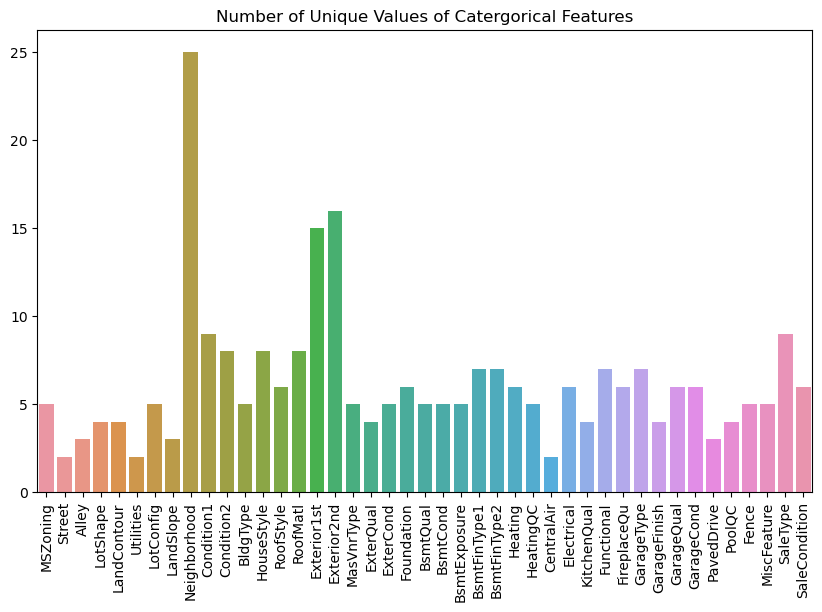

In [14]:
#create a list containing the number of unique values in each categorical column 
unique_values=[]
for col in object_cols:
    unique_values.append(dataset[col].unique().size)
#visualise the number of unique values within each categorical feature
plt.figure(figsize=(10, 6))
plt.title('Number of Unique Values of Catergorical Features')
plt.xticks(rotation=90)
sns.barplot(x=object_cols, y=unique_values)

C:\Users\danie\AppData\Local\Temp\ipykernel_14144\3166150828.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(17, 6, index)


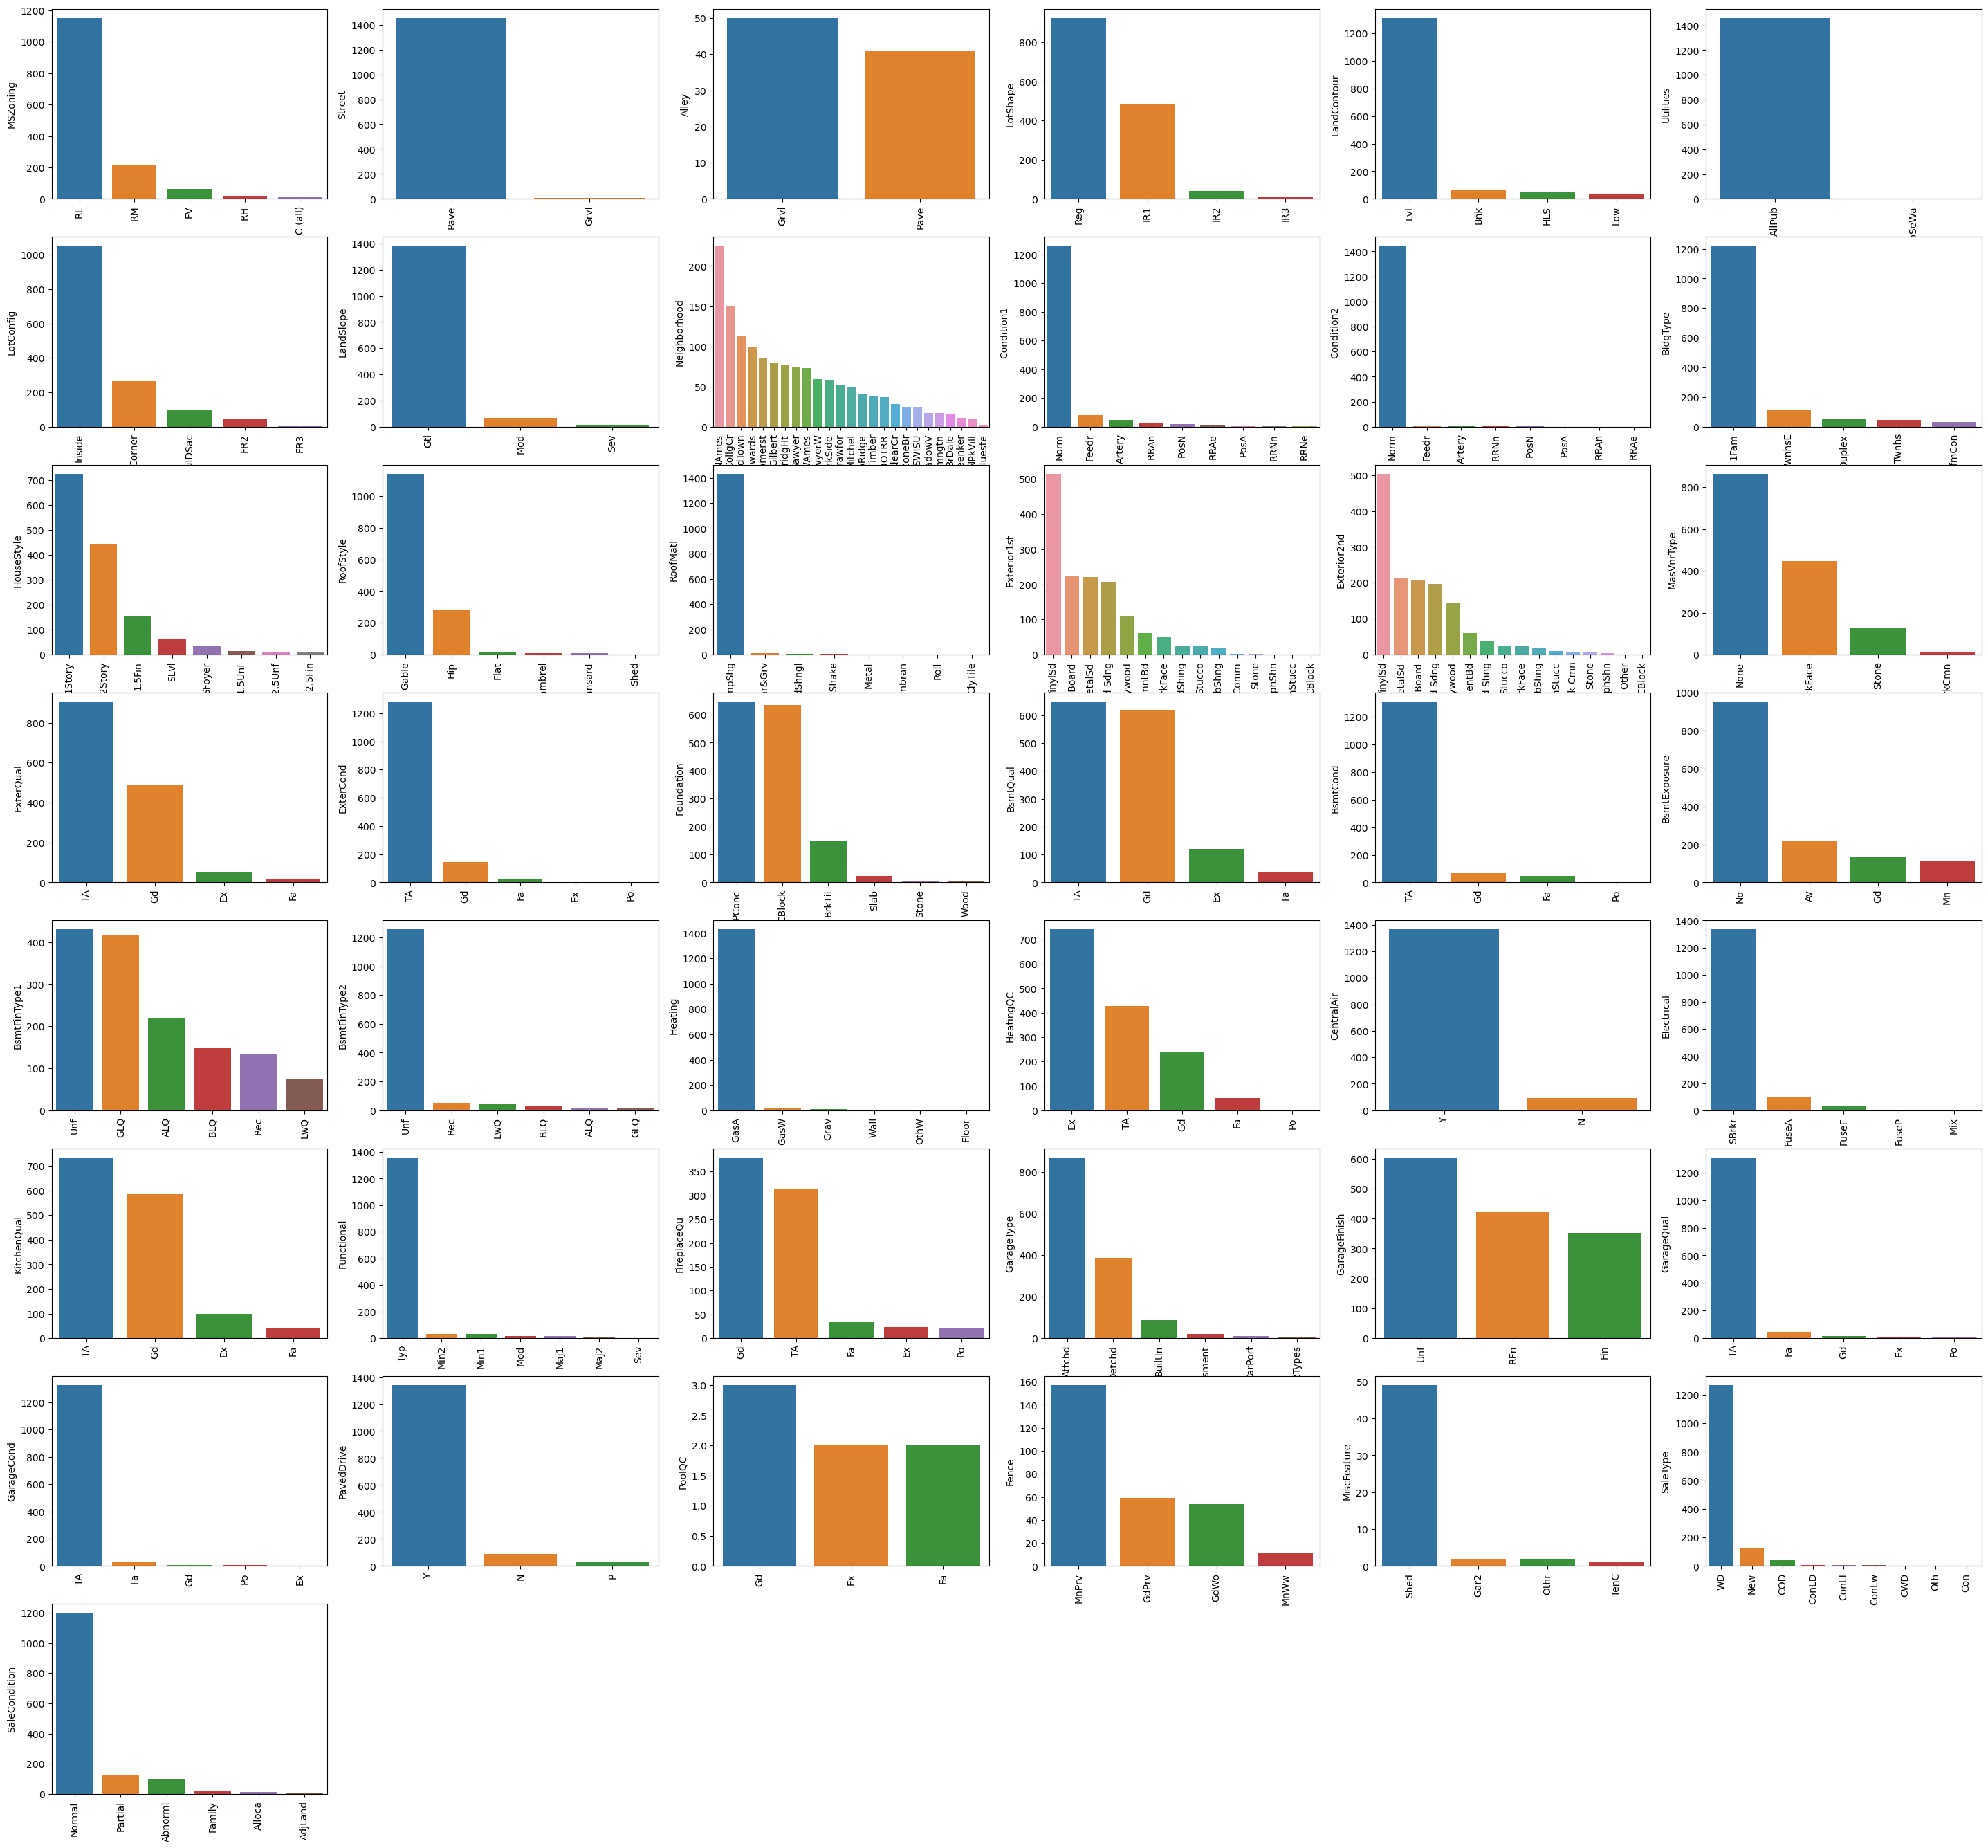

In [15]:
#visualise the number of unique object values in the dataset 
plt.figure(figsize=(36, 72))
plt.title('Distribution of Each Catergorical Feature')
plt.xticks(rotation=90)
index = 1
#find count of each feature and visualise in a bar-graph 
for col in object_cols:
    y = dataset[col].value_counts()
    plt.subplot(17, 6, index)
    plt.xticks(rotation=90)
    sns.barplot(x=list(y.index), y=y)
    index+=1

# OneHotEncoder
Map catergorical data to integer values so that the regression model can use the data.

In [16]:
#collect all columns which have object data type 
o = (dataset.dtypes == 'object')
#create list of all columns which are of an object datatype 
object_cols = list(o[o].index)
#print a list of all columns which are non-numeric 
print('Catergorical Variables:')
print(object_cols)
#print total number of non-numeric columns 
print('No. of Catergorical Features: ', len(object_cols))

Catergorical Variables:
['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
No. of Catergorical Features:  43


In [17]:
#create instance of one-hot encoder 
OH_encoder = OneHotEncoder(sparse_output=False)
#apply the one-hot encoder to the object columns and convert the output to a pandas dataframe
OH_cols = pd.DataFrame(OH_encoder.fit_transform(dataset[object_cols]))
#set the index of the new dataframe to the same as the original dataframe 
OH_cols.index = dataset.index
#set the column names of the new dataframe as the columns as the output features names for the transformation
OH_cols.columns = OH_encoder.get_feature_names_out()
#drop the object columns from the original dataset 
dataset = dataset.drop(object_cols, axis=1)
#add the new columns created by the O-H encoder to the original dataset 
dataset = pd.concat([dataset, OH_cols], axis=1)

In [18]:
#print the shape of the dataframe to see how many columns have been added by the One-hot encoder
dataset.shape

(1460, 305)

# Handle Missing Data
Use the KNNImputer to handle missing data by filling in null values based in the mean values of the nearest neighbours. This helps to retain data as columns/rows with null values do not have to be discarded, this will help avoid overfitting as more data is available to the model.

In [19]:
#function to report missing data 
def report_missing_data(dataset):
    #get total of null values in each column and print in descending order
    total_missing = dataset.isnull().sum().sort_values(ascending=False)
    print(total_missing)

In [20]:
#check null values using method before imputer is applied 
report_missing_data(dataset)

LotFrontage              259
GarageYrBlt               81
MasVnrArea                 8
MSSubClass                 0
BsmtFinType1_GLQ           0
                        ... 
Condition2_PosA            0
Condition2_Norm            0
Condition2_Feedr           0
Condition2_Artery          0
SaleCondition_Partial      0
Length: 305, dtype: int64


In [21]:
#create instance of KNNImputer
imputer = KNNImputer()
#apply imputer to the dataset which outputs a numpy array 
after_imputer = imputer.fit_transform(dataset)
#convert back to a pandas dataframe 
after_imputer_df = pd.DataFrame (after_imputer, columns=dataset.columns)

In [22]:
#check imputer has filled in all null values 
report_missing_data(after_imputer_df)

MSSubClass               0
BsmtFinType1_BLQ         0
BsmtFinType2_BLQ         0
BsmtFinType2_ALQ         0
BsmtFinType1_nan         0
                        ..
Condition2_Norm          0
Condition2_Feedr         0
Condition2_Artery        0
Condition1_RRNn          0
SaleCondition_Partial    0
Length: 305, dtype: int64


# Train/Test Split

Test size set to 0.1 to ensure a large portion of the dataset is used for training. Random state set to 55 to ensure dataset is shuffled sufficiently. These two parameters help avoid overfitting which is a common occurence for Random Forests.

In [23]:
#split data set into training and test data 
data_train, data_test = train_test_split(after_imputer_df, test_size=0.1, random_state=55)

In [24]:
#drop target variable from X training data 
X_train = data_train.drop('SalePrice', axis=1)
#load target variable into y training data 
y_train = data_train['SalePrice'].copy()

In [53]:
#check shape of X and y data
X_train.shape, y_train.shape

((1314, 304), (1314,))

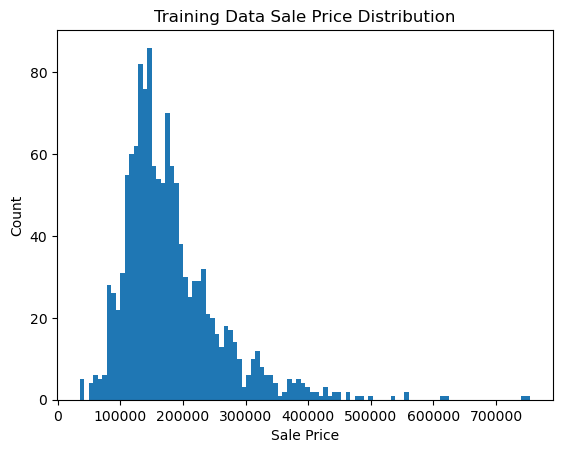

In [26]:
#visualise distribution of target variable in training data 
plt.hist(data_train['SalePrice'], bins=100)
plt.title('Training Data Sale Price Distribution')
plt.ylabel('Count')
plt.xlabel('Sale Price')
plt.show()

Can see that the training data does not contain much data for house prices of £400k onwards therefore the accuracy of these predictions is likely to be low. 

In [27]:
# drop target variable from X test data
X_test = data_test.drop('SalePrice', axis=1)
# load target variable into y test data 
y_test = data_test['SalePrice'].copy()

In [28]:
#check shape of X and y test data
X_test.shape, y_test.shape

((146, 304), (146,))

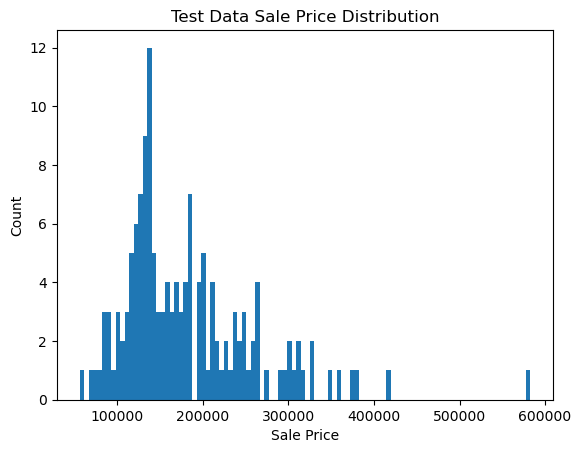

In [29]:
# check distribution of target variable in test data 
plt.hist(data_test['SalePrice'], bins=100)
plt.title('Test Data Sale Price Distribution')
plt.ylabel('Count')
plt.xlabel('Sale Price')
plt.show()

The above distribution graph shows that the test data will require the model to predict two values over £400,000, as mentioned earlier these predictions are likely to be accurate. 

# Model Tuning

Hyperparameter tuning done using Scikit-Learn's .GridSearchCV(). If a parameter is not shown when printing '.best_estimator_' then that indicates to use the default parameter. 

In [39]:
#create the grid containing the defined parameters for the grid search to test 
param_grid = {
    #number of trees
    'n_estimators': [128, 256, 384],
    #number of features to consider when looking for the best split
    'max_features': ['sqrt', 'log2', 1],
    #minimum number of samples required at a leaf node in order to split
    'min_samples_leaf':[0.2, 0.5, 1],
    #number of samples to train each base estimator 
    'max_samples': [0.8, 0.9, None]
}
#create instance of GridSearchCV for a RandomForestRegressor using the parameter grid
grid_search = GridSearchCV(RandomForestRegressor(), 
                          param_grid=param_grid, n_jobs=-1)
#fit the GridSearchCV to the training data to find best model for this dataset
grid_search.fit(X_train, y_train)
#print the parameters of the best model  
print('Best estimator: ', grid_search.best_estimator_)
#print the model's Mean cross-validated score
print('Best score: ', grid_search.best_score_)

Best estimator:  RandomForestRegressor(max_features='sqrt', max_samples=0.9, n_estimators=256)
Best score:  0.8365675164799201


# Tuned Random Forest Regression Model

In [41]:
# create model according to parameters from GridSearchCV 
tuned_random_forest = RandomForestRegressor(n_estimators=256, max_features='sqrt',max_samples=0.9, oob_score = True)
# fit the model to training data 
tuned_random_forest.fit(X_train, y_train)
#make predictions on training data 
tuned_y_pred = tuned_random_forest.predict(X_train)

# retrieve the model's Out-of-Bag Score
oob_score = tuned_random_forest.oob_score_
#print the out-of-bag score
print(f'Out-of-Bag Score: {oob_score}')

Out-of-Bag Score: 0.847805073836051


# Default Random Forest Regression Model

In [46]:
# create a model with default parameters with out of bag score set to 'True' to evaluate
random_forest = RandomForestRegressor(oob_score = True)
# fit the default model to training data 
random_forest.fit(X_train, y_train)
#make predictions on training data 
y_pred = random_forest.predict(X_train)

# retrieve the default model's Out-of-Bag Score
oob_score = random_forest.oob_score_
#print the out-of-bag score
print(f'Out-of-Bag Score: {oob_score}')

Out-of-Bag Score: 0.8544822972066627


Can be seen that the tuned RandomForestRegressor has a lower out-of-bag score than the default regressor. 

# Evaluation
Compare the accuracy scores on the training data to the test data for both Random Forest Models. This will identify whether the model is overfitting, this is something which decision trees are prone to doing.

In [33]:
# method to visualise model prediction accuracy 
def plot_pred_true(ypred, ytrue):
    #create a dataframe of predicted and true sale prices 
    df = pd.DataFrame([ypred, ytrue]).T
    df.columns=['pred', 'true']
    #create a scatter plot with a line representing true sale price values 
    plt.plot([min(ytrue), max(ytrue)], [min(ytrue), max(ytrue)], linestyle='--', color='red')
    plt.title('Actual vs Predicted SalePrice')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.scatter(df['pred'], df['true'])

# Tuned Model Accuracy Visualized

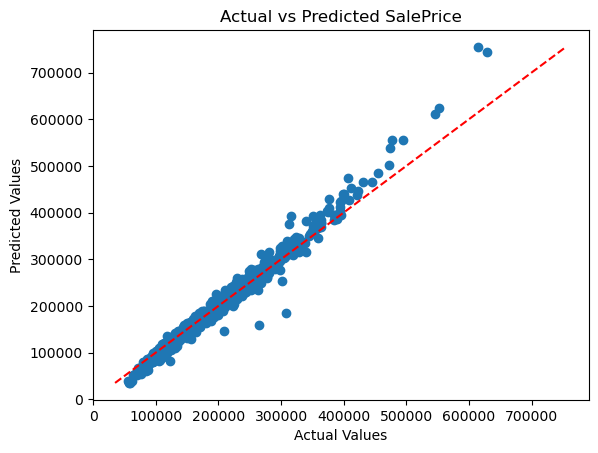

In [55]:
#plot prediction accuracy on training set 
plot_pred_true(tuned_y_pred, y_train)

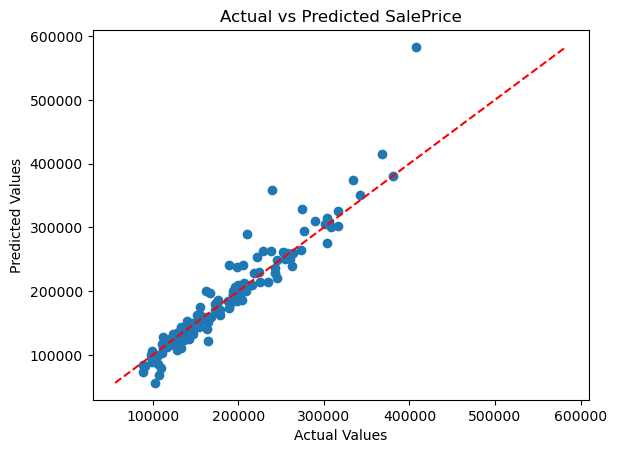

In [56]:
#make predictions on test dataset using the tuned model 
tuned_test_pred = tuned_random_forest.predict(X_test)
#plot prediction accuracy on test set 
plot_pred_true(tuned_test_pred, y_test)
plt.show()

# Default Model Accuracy Visualization

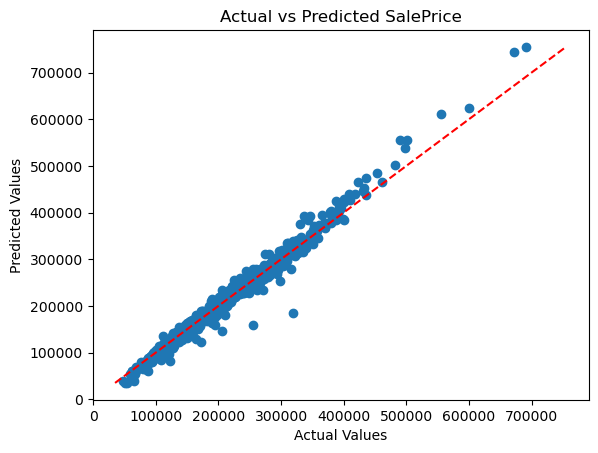

In [57]:
#plot prediction accuracy on training data
plot_pred_true(y_pred, y_train)

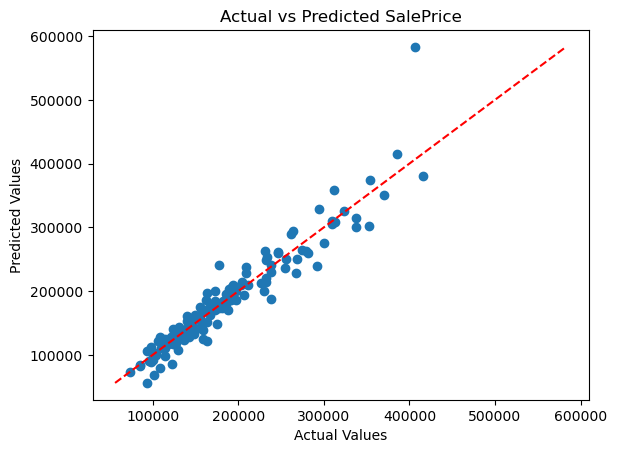

In [58]:
#make predictions on test set using the default model 
test_pred = random_forest.predict(X_test)
#plot predictions on test data
plot_pred_true(test_pred, y_test)
plt.show()

# Evaluation of Models

In [51]:
#SCORES FOR TUNED MODEL 
print('Tuned Model Scores')
#print training data accuracy 
print('\nTraining Data Accuracy:')
#get Mean Absolute Percentage Error on training data
train_mape = mean_absolute_percentage_error(y_train, tuned_y_pred)
print('Mean Absolute Percentage Error: ', train_mape)
#get R-squared on training data
train_r2 = r2_score(y_train, tuned_y_pred)
print('R-squared: ', train_r2)

#print test data accuracy
print('\nTest Data Accuracy:')
#get Mean Absolute Percentage Error on test data
mape = mean_absolute_percentage_error(y_test, tuned_test_pred)
print('Mean Absolute Percentage Error: ', mape)

#get R-squared on test data
r2 = r2_score(y_test, tuned_test_pred)
print('R-squared: ', r2)

#SCORES FOR DEFAULT MODEL 
print('\nDefault Model Scores')
#print training data accuracy 
print('\nTraining Data Accuracy:')
#get Mean Absolute Percentage Error on training data
train_mape = mean_absolute_percentage_error(y_train, y_pred)
print('Mean Absolute Percentage Error: ', train_mape)
#get R-squared on training data
train_r2 = r2_score(y_train, y_pred)
print('R-squared: ', train_r2)

#print test data accuracy
print('\nTest Data Accuracy:')
#get Mean Absolute Percentage Error on test data
mape = mean_absolute_percentage_error(y_test, test_pred)
print('Mean Absolute Percentage Error: ', mape)

#get R-squared on test data
r2 = r2_score(y_test, test_pred)
print('R-squared: ', r2)

Tuned Model Scores

Training Data Accuracy:
Mean Absolute Percentage Error:  0.0433556886601245
R-squared:  0.9741086161139908

Test Data Accuracy:
Mean Absolute Percentage Error:  0.07692534133514341
R-squared:  0.9016227939566992

Default Model Scores

Training Data Accuracy:
Mean Absolute Percentage Error:  0.03902266112598666
R-squared:  0.9805109446914297

Test Data Accuracy:
Mean Absolute Percentage Error:  0.08374025212635271
R-squared:  0.9088370365830875
